In [2]:
!pip install -q pyspark imagehash kaggle

In [3]:
!kaggle datasets download vishesh1412/celebrity-face-image-dataset

Dataset URL: https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset
License(s): CC0-1.0
 89% 47.0M/52.9M [00:00<00:00, 97.5MB/s]
100% 52.9M/52.9M [00:00<00:00, 99.5MB/s]


In [4]:
!unzip  celebrity-face-image-dataset.zip

Archive:  celebrity-face-image-dataset.zip
  inflating: Celebrity Faces Dataset/Angelina Jolie/001_fe3347c0.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/002_8f8da10e.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/003_57612506.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/004_f61e7d0c.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/005_582c121a.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/006_9135205d.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/007_cabbfcbb.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/008_d1f87068.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/009_fb3e6174.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/010_f99d79e3.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/011_7344ca35.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/012_cfcd4007.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/013_95ecbd39.jpg  
  inflating: Celebrity Faces Datas

# LSH Algorithm

In [6]:
import imagehash
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from glob import glob

In [7]:
data = {
    "id": [],
    "features": [],
}

root = "/content/Celebrity Faces Dataset/Robert Downey Jr"
for f in sorted(glob(f"{root}/*")):
  img = Image.open(f)
  # img = img.resize((112, 112), Image.LANCZOS)
  # img = Image.fromarray(img
  blur = img.filter(ImageFilter.GaussianBlur(radius=5))
  img = blur.convert("L").resize((112, 112), Image.LANCZOS)
  # img.save(f"sample_images/{f.split('/')[-1]}")
  data['id'].append(f.split("/")[-1])
  data['features'].append(np.array(img).astype(int).ravel() / 255.0)

df = pd.DataFrame(data)

In [8]:
df

,id,features
0,001_a51bb26a.jpg,"[0.49411764705882355, 0.49411764705882355, 0.4..."
1,002_cc92e159.jpg,"[0.5254901960784314, 0.5137254901960784, 0.498..."
2,003_e18853f8.jpg,"[0.5372549019607843, 0.5450980392156862, 0.549..."
3,004_29776ffe.jpg,"[0.7372549019607844, 0.7176470588235294, 0.698..."
4,005_8af3cada.jpg,"[0.01568627450980392, 0.01568627450980392, 0.0..."
...,...,...
95,096_84100579.jpg,"[0.27450980392156865, 0.27058823529411763, 0.2..."
96,097_833dba65.jpg,"[0.1607843137254902, 0.1607843137254902, 0.152..."
97,098_b78efdc8.jpg,"[0.8549019607843137, 0.8274509803921568, 0.776..."
98,099_0d04ca3f.jpg,"[0.9647058823529412, 0.9529411764705882, 0.937..."


In [9]:
df.to_parquet("patches.parquet")

In [10]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors

import random
spark = SparkSession.builder.appName("LSHS").getOrCreate()

In [11]:
data = spark.read.parquet("patches.parquet")
data

DataFrame[id: string, features: array<double>]

In [12]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import col, udf

In [13]:
def array_to_sparse(row):
    res = Vectors.dense(row)
    return res

udf_array_to_sparse = udf(array_to_sparse, VectorUDT())

In [14]:
data = data.withColumn("features", udf_array_to_sparse(data["features"]))
data

DataFrame[id: string, features: vector]

In [15]:
data.show()

+----------------+--------------------+
|              id|            features|
+----------------+--------------------+
|001_a51bb26a.jpg|[0.49411764705882...|
|002_cc92e159.jpg|[0.52549019607843...|
|003_e18853f8.jpg|[0.53725490196078...|
|004_29776ffe.jpg|[0.73725490196078...|
|005_8af3cada.jpg|[0.01568627450980...|
|006_c26122bd.jpg|[0.01960784313725...|
|007_ecb8599e.jpg|[0.36862745098039...|
|008_79cd0b7b.jpg|[0.60784313725490...|
|009_49237aa0.jpg|[0.03137254901960...|
|010_991a88dc.jpg|[0.08627450980392...|
|011_da108a07.jpg|[0.23137254901960...|
|012_e3dd7d69.jpg|[1.0,1.0,1.0,1.0,...|
|013_9e49009e.jpg|[0.71764705882352...|
|014_75f93e62.jpg|[0.13333333333333...|
|015_76c98a92.jpg|[0.32549019607843...|
|016_375490e8.jpg|[0.61960784313725...|
|017_fd82d064.jpg|[0.42352941176470...|
|018_0d23eccd.jpg|[0.30588235294117...|
|019_ac261615.jpg|[0.32549019607843...|
|020_b12140b8.jpg|[0.21176470588235...|
+----------------+--------------------+
only showing top 20 rows



In [16]:
data.count()

100

In [18]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

In [19]:
lsh = BucketedRandomProjectionLSH(bucketLength=3.0)
lsh.setInputCol("features")
lsh.setOutputCol("id_match")
lsh.setSeed(42)
model = lsh.fit(data)

In [20]:
similar_keys_df = model.approxSimilarityJoin(data, data, 50)

In [21]:
similar_keys_df.count()

5208

In [22]:
similar_keys_df.filter(col("distCol") <= 25.0).filter(col("distCol") != 0.0).count()

254

In [23]:
import matplotlib.pyplot as plt

(-0.5, 473.5, 581.5, -0.5)

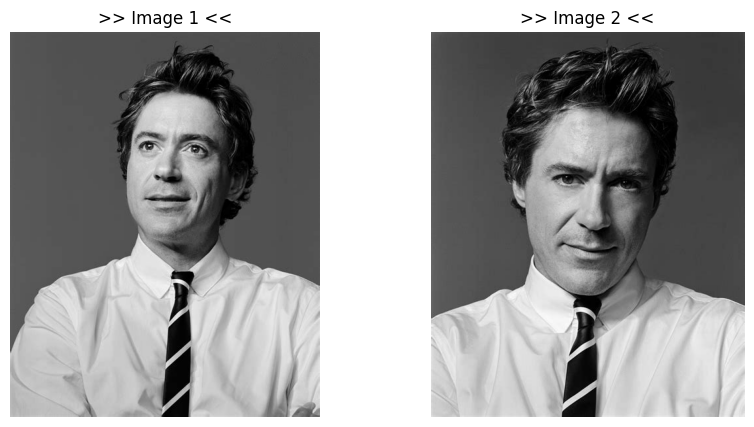

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open(f"{root}/067_fb66d8ac.jpg"))
ax[0].set_title(">> Image 1 <<")
ax[0].axis("off")

ax[1].imshow(Image.open(f"{root}/058_4ed85318.jpg"))
ax[1].set_title(">> Image 2 <<")
ax[1].axis("off")


In [ ]:
data.show()

+----------------+--------------------+
|              id|            features|
+----------------+--------------------+
|001_a51bb26a.jpg|[0.49411764705882...|
|002_cc92e159.jpg|[0.52549019607843...|
|003_e18853f8.jpg|[0.53725490196078...|
|004_29776ffe.jpg|[0.73725490196078...|
|005_8af3cada.jpg|[0.01568627450980...|
|006_c26122bd.jpg|[0.01960784313725...|
|007_ecb8599e.jpg|[0.36862745098039...|
|008_79cd0b7b.jpg|[0.60784313725490...|
|009_49237aa0.jpg|[0.03137254901960...|
|010_991a88dc.jpg|[0.08627450980392...|
|011_da108a07.jpg|[0.23137254901960...|
|012_e3dd7d69.jpg|[1.0,1.0,1.0,1.0,...|
|013_9e49009e.jpg|[0.71764705882352...|
|014_75f93e62.jpg|[0.13333333333333...|
|015_76c98a92.jpg|[0.32549019607843...|
|016_375490e8.jpg|[0.61960784313725...|
|017_fd82d064.jpg|[0.42352941176470...|
|018_0d23eccd.jpg|[0.30588235294117...|
|019_ac261615.jpg|[0.32549019607843...|
|020_b12140b8.jpg|[0.21176470588235...|
+----------------+--------------------+
only showing top 20 rows



In [ ]:
data.show()

+----------------+--------------------+
|              id|            features|
+----------------+--------------------+
|001_a51bb26a.jpg|[0.49411764705882...|
|002_cc92e159.jpg|[0.52549019607843...|
|003_e18853f8.jpg|[0.53725490196078...|
|004_29776ffe.jpg|[0.73725490196078...|
|005_8af3cada.jpg|[0.01568627450980...|
|006_c26122bd.jpg|[0.01960784313725...|
|007_ecb8599e.jpg|[0.36862745098039...|
|008_79cd0b7b.jpg|[0.60784313725490...|
|009_49237aa0.jpg|[0.03137254901960...|
|010_991a88dc.jpg|[0.08627450980392...|
|011_da108a07.jpg|[0.23137254901960...|
|012_e3dd7d69.jpg|[1.0,1.0,1.0,1.0,...|
|013_9e49009e.jpg|[0.71764705882352...|
|014_75f93e62.jpg|[0.13333333333333...|
|015_76c98a92.jpg|[0.32549019607843...|
|016_375490e8.jpg|[0.61960784313725...|
|017_fd82d064.jpg|[0.42352941176470...|
|018_0d23eccd.jpg|[0.30588235294117...|
|019_ac261615.jpg|[0.32549019607843...|
|020_b12140b8.jpg|[0.21176470588235...|
+----------------+--------------------+
only showing top 20 rows



(-0.5, 473.5, 586.5, -0.5)

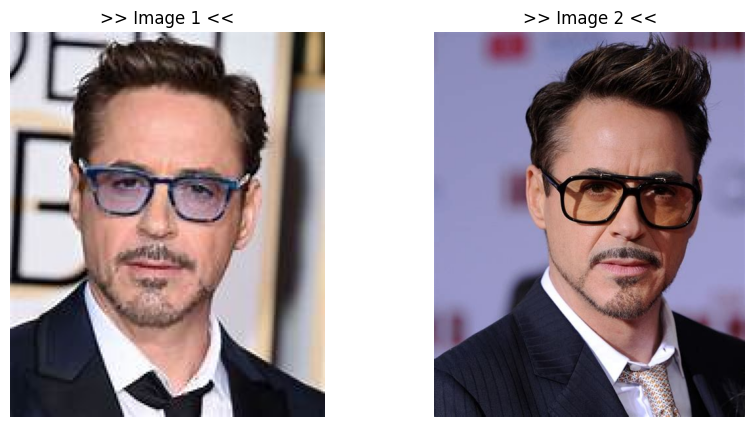

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open(f"{root}/004_29776ffe.jpg"))
ax[0].set_title(">> Image 1 <<")
ax[0].axis("off")

ax[1].imshow(Image.open(f"{root}/003_e18853f8.jpg"))
ax[1].set_title(">> Image 2 <<")
ax[1].axis("off")